# Database Exploration

By **Franklin Oliveira**

-----
This notebook contains some code written in order for me (Franklin) to get accquainted with the `crustacea` database. Here you'll find some basic data treatment and some insights that did show up as I started to understand all the information on file <font color='blue'>'Planilha geral Atualizda FINAL com correções.xlsx'</font>.

In [1]:
import datetime
import numpy as np
import pandas as pd

from collections import defaultdict

# pacotes para visualização rápida
import seaborn as sns
import matplotlib.pyplot as plt

# Waffle Charts
from pywaffle import Waffle 
# docs: https://pywaffle.readthedocs.io/en/latest/examples/block_shape_distance_location_and_direction.html

# pacote para visualização principal
import altair as alt

# habilitando renderizador para notebook
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

## Importing data...

In [2]:
excel = pd.ExcelFile('Planilha geral Atualizda FINAL com correções.xlsx')
sheet_name = excel.sheet_names

print('The excel file contains the following sheets:', sheet_name)
print('\nDatabase is in sheet:', sheet_name[0])

The excel file contains the following sheets: ['Banco de Dados Colecao Carcinol', 'Planilha1']

Database is in sheet: Banco de Dados Colecao Carcinol


In [3]:
# db = excel.parse(sheet_name[0], sep=';', encoding='utf-8-sig')
db = pd.read_csv('db.csv', sep=',', encoding='utf-8-sig', low_memory=False)
print(f'The database has {db.shape[0]} rows and {db.shape[1]} columns.')

The database has 28689 rows and 132 columns.


In [4]:
# copying database to another variable to make a few changes keeping the original intact
crustaceas = db.copy()

<br>

### Name columns

`Determiner First Name1` e `Determiner Last Name1`

In [5]:
def treat_names(name, pos='first'):
    '''
    Treat names keeping NaN as such.
    
    Arguments: 
        - name: name to be treated. 
        - pos (str): name position. One of ['first', 'last']
    '''
    if type(name) == str and pos == 'first':     # primeiro nome
        
        if len(name.split(' ')) > 1:             # trata se o nome é composto (+ de um nome)
            return str(name).strip().split(' ')[0].capitalize()
        else:
            return str(name).strip().capitalize()
    
    elif type(name) == str and pos == 'last':    # último sobrenome
        
        if len(name.split(' ')) > 1:             # trata se o último nome é composto (+ de um sobrenome)
            return str(name).strip().split(' ')[-1].capitalize()
        else:
            return str(name).strip().capitalize()   
    else:
        return name

In [6]:
crustaceas['Determiner First Name1'] = crustaceas['Determiner First Name1'].apply(treat_names)
# crustaceas['Determiner First Name1'].value_counts()

In [7]:
crustaceas['Determiner Last Name1'] = crustaceas['Determiner Last Name1'].apply(lambda x:
                                                                treat_names(x, pos='last'))
# crustaceas['Determiner Last Name1'].value_counts()

In [8]:
# creating column with First and Last name for identification
crustaceas['Determiner First_and_Last Name'] = crustaceas['Determiner First Name1'] + ' ' + crustaceas['Determiner Last Name1']

#### removing '\n' from column names

In [9]:
db.columns = [str(col).replace(r'\n','') for col in db.columns]

#### closer look on some columns...

In [10]:
# db[['Species1', 'Species Author1', 'Type Status1', 'Qualifier1', 'Determiner First Name1',
#       'Determiner Middle1', 'Determiner Last Name1', 'Determined Date1']]

## preparing data for charts...

Column: `Type Status1`

In [11]:
crustaceas['Type Status1'].value_counts()

Paratipo         433
Holotipo         203
ParaTIPO         142
PARATIPO         120
HOLOTIPO          82
Alotipo           69
ALOTIPO           12
Topotipo           6
Neotipo            5
Sintipo            5
Lectotipo          4
Paralectotipo      4
TOPOTIPO           3
PARALECTOTIPO      2
Tipo               2
MATERIAL TIPO      2
NEOTIPO            1
Co-tipo            1
Material Tipo      1
Name: Type Status1, dtype: int64

Let's begin cleaning this data and lowering all cases.

In [12]:
crustaceas['Type Status1'] = crustaceas['Type Status1'].str.strip().str.lower().str.capitalize()

In [13]:
crustaceas['Genus1'].str.lower().value_counts()

indeterminado       9615
numero reservado     569
ampelisca            363
macrobrachium        359
megabalanus          290
                    ... 
entomopsyllus          1
ascidiopontius         1
nessipus               1
odontozona             1
andenoniscus           1
Name: Genus1, Length: 1320, dtype: int64

In [14]:
for col in crustaceas.columns:
    print('-', col)

- Catalog Number
- Cataloger First Name
- Cataloger Middle
- Cataloger Last Name
- Cataloged Date
- on line
- Input Type
- Alt Cat Number
- reserved
- Object Condition
- Count Amount
- associatedTaxa
- Females
- Males
- Ind
- Adults
- Young
- Larvae
- Egg Mass
- Measurement\n Records
- Remarks
- Kingdom
- Phylum1
- Subphylum1
- Class1
- Subclass1
- Infraclass1
- Superorder1
- Order1
- Suborder1
- Infraorder1
- Superfamily1
- Family1
- Subfamily1
- Tribe1
- Genus1
- Species1
- Species Author1
- Type Status1
- Qualifier1
- Determiner First Name1
- Determiner Middle1
- Determiner Last Name1
- Determined Date1
- Phylum2
- Subphylum2
- Class2
- Subclass2
- Infraclass2
- Superorder2
- Order2
- Suborder2
- Infraorder2
- Superfamily2
- Family2
- Subfamily2
- Tribe2
- Genus2
- Species2
- Species Author2
- Type Status2
- Qualifier2
- Determiner First Name2
- Determiner Middle2
- Determiner Last Name2
- Determined Date2
- Prep Type1
- Count 1
- Description 1
- Prepared First Name By1
- Prepared M

In [15]:
crustaceas['Type Status1'].value_counts()

Paratipo         695
Holotipo         285
Alotipo           81
Topotipo           9
Neotipo            6
Paralectotipo      6
Sintipo            5
Lectotipo          4
Material tipo      3
Tipo               2
Co-tipo            1
Name: Type Status1, dtype: int64

### Collecting date (year), class and kingdom 

Columns: `Cataloged Date` - `Class1` - `Kingdom`

In [16]:
Table = crustaceas[['Cataloged Date','Class1','Kingdom', 'Species1', 'Type Status1',
                   'Determiner First_and_Last Name', 'Determiner First Name1',
                   'Determiner Last Name1']].copy()

d = []
counter=0
for row in Table['Cataloged Date']:
    if not str(row).find('/')==-1:
        dates_values = str(row).split("/")
        year = int(dates_values[0])
        month = int(dates_values[1])
        if (month>1) and (month<12):
            #store the year and month in a datetime datatype for later sorting
            dateRecord = datetime.datetime(year,month,1)    
            
    d.append({'year':year, 'class':Table.loc[counter,'Class1'],
              'kingdom':Table.loc[counter,'Kingdom'], 'species':Table.loc[counter,'Species1'],
              'type_status':Table.loc[counter,'Type Status1'], 
              'determiner_first_and_last_name':Table.loc[counter,'Determiner First_and_Last Name'],
              'determiner_first_name':Table.loc[counter,'Determiner First Name1'],
              'determiner_last_name':Table.loc[counter,'Determiner Last Name1']              
             })
    counter = counter+1
    
NewTable = pd.DataFrame(d)
NewTable.head()

year         class   kingdom    species type_status  \
0  1980  Malacostraca  Animalia   schmitti         NaN   
1  1980  Malacostraca  Animalia   schmitti         NaN   
2  1980  Malacostraca  Animalia   schmitti         NaN   
3  1980  Malacostraca  Animalia  schmitti          NaN   
4  1980  Malacostraca  Animalia   schmitti         NaN   

  determiner_first_and_last_name determiner_first_name determiner_last_name  
0                   Alceu Castro                 Alceu               Castro  
1                   Alceu Castro                 Alceu               Castro  
2                   Alceu Castro                 Alceu               Castro  
3                   Maria Correa                 Maria               Correa  
4                   Alceu Castro                 Alceu               Castro

### counting number of registers per year

In [17]:
classes = NewTable['class'].unique()
classes

e = []
countam = 0
for classSp in classes:
    p = NewTable.loc[NewTable.loc[:,'class']==classSp,:]
#     p.year.value_counts()
    numbers = p.year.value_counts(sort=False)
#     print(p.year.value_counts(sort=False))
    for oneyear in p.year.unique():
        countam = countam + numbers.loc[oneyear]
        
        # PROBLEMA: pega só a primeira informação de cada ano (type_status está ficando vazia)
        e.append({'class':p['class'].unique()[0],'kingdom':p.kingdom.unique()[0],
                  'year':oneyear,'amount':numbers.loc[oneyear], 
                 'species':p.species.unique()[0], 'type_status':p.type_status.unique()[0],
                 'determiner_first_and_last_name':p.determiner_first_and_last_name.unique()[0]})
NewTable_Years = pd.DataFrame(e)
NewTable_Years.head(2)

class   kingdom  year  amount   species  type_status  \
0  Malacostraca  Animalia  1980      52  schmitti          NaN   
1  Malacostraca  Animalia  2009     288  schmitti          NaN   

  determiner_first_and_last_name  
0                   Alceu Castro  
1                   Alceu Castro

### creating column `year` in crustaceas

In [18]:
def catch_year(row):
    if not str(row).find('/')==-1:
        dates_values = str(row).split("/")
        year = int(dates_values[0])
        month = int(dates_values[1])
        return year
    else:
        return np.NaN

In [19]:
crustaceas['year'] = crustaceas['Cataloged Date'].apply(catch_year)

### preparing taxonomy columns

`Kingdom` - `Phylum1` - `Subphylum1` - `Class1` - `Subclass1` - `Infraclass1` - `Superorder1` - `Order1` - `Suborder1` - `Infraorder1` - `Superfamily1` - `Family1` - `Subfamily1` - `Tribe1` - `Genus1` - `Species1`

In [20]:
taxon_columns = crustaceas.columns[21:37]

In [21]:
def treat_str(x):
    return str(x).lower().capitalize().strip()

In [22]:
for col in taxon_columns:
    print(f'Adjusting column {col}')
    crustaceas[col] = crustaceas[col].apply(treat_str)

Adjusting column Kingdom
Adjusting column Phylum1
Adjusting column Subphylum1
Adjusting column Class1
Adjusting column Subclass1
Adjusting column Infraclass1
Adjusting column Superorder1
Adjusting column Order1
Adjusting column Suborder1
Adjusting column Infraorder1
Adjusting column Superfamily1
Adjusting column Family1
Adjusting column Subfamily1
Adjusting column Tribe1
Adjusting column Genus1
Adjusting column Species1


### treating cataloger's name 

In this step, we're going to put together cataloger's first and last name. 

`Cataloger First Name` + `Cataloger Last Name`

Just concatenating those two columns is not satisfactory because there's some dirt in these data columns. So, let's begin by treating them...

In [23]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [24]:
teste = crustaceas['Cataloged Date'].value_counts()
teste = teste.reset_index().rename(columns={'index':'year', 'Cataloged Date':'counts'})

In [25]:
# min e max para eixo X (year)
min_x = teste['year'].min()
max_x = teste['year'].max()

In [26]:
teste['year'] = teste['year'].apply(lambda x:x.split('/')[0]).astype(int)
teste = teste.groupby('year').sum().reset_index() # soma do total de bichos coletados por ano

## Gráficos

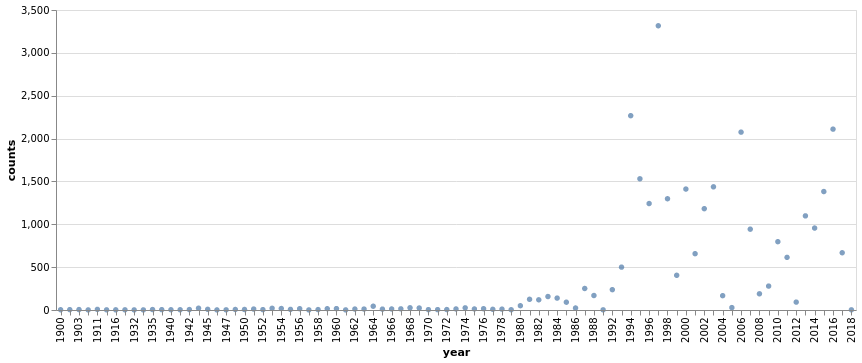

In [27]:
alt.Chart(data= teste, width=800).mark_circle().encode(
    x= alt.X('year', type='ordinal'),
    y= alt.Y('counts', type='quantitative')
)

x: Species1, cor: Type Status1, size: counts

In [28]:
teste1 = NewTable.drop_duplicates()

In [29]:
teste1.head(2)

year         class   kingdom    species type_status  \
0  1980  Malacostraca  Animalia   schmitti         NaN   
3  1980  Malacostraca  Animalia  schmitti          NaN   

  determiner_first_and_last_name determiner_first_name determiner_last_name  
0                   Alceu Castro                 Alceu               Castro  
3                   Maria Correa                 Maria               Correa

In [30]:
NewTable['year'] = NewTable['year'].astype(int)

<font color='red' size='5'>**OBS:** há pontos sobrepostos nos gráficos abaixo. Para resolver isso, preciso manter apenas uma informação para cada par (pesquisador, ano) </font>

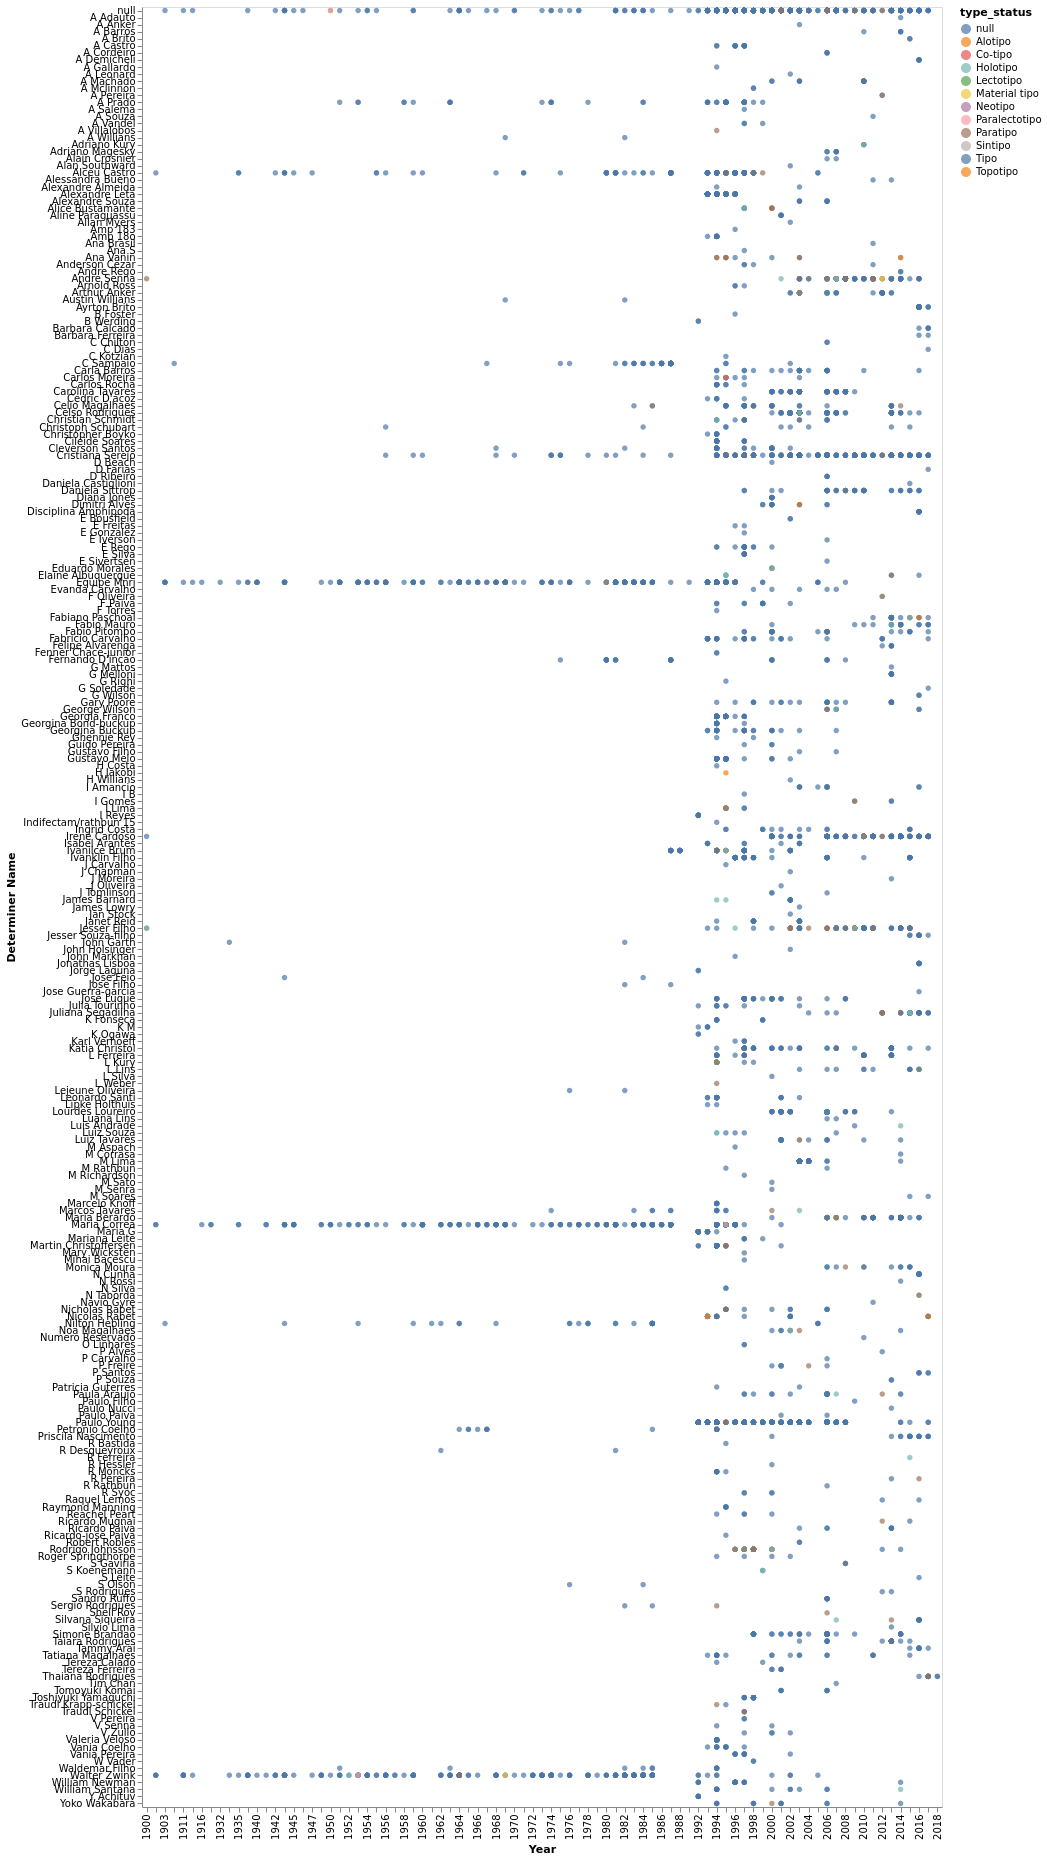

In [31]:
g1 = alt.Chart(teste1, width=800, height=1800).mark_circle().encode(
    x= alt.X('year', type='ordinal', title='Year'),
    y= alt.Y('determiner_first_and_last_name', type='nominal', title='Determiner Name'),
    color= alt.Color('type_status')
)

# salvando o gráfico
# g1.save('determiner_and_year.svg')
# g1.save('determiner_and_year.html')

g1

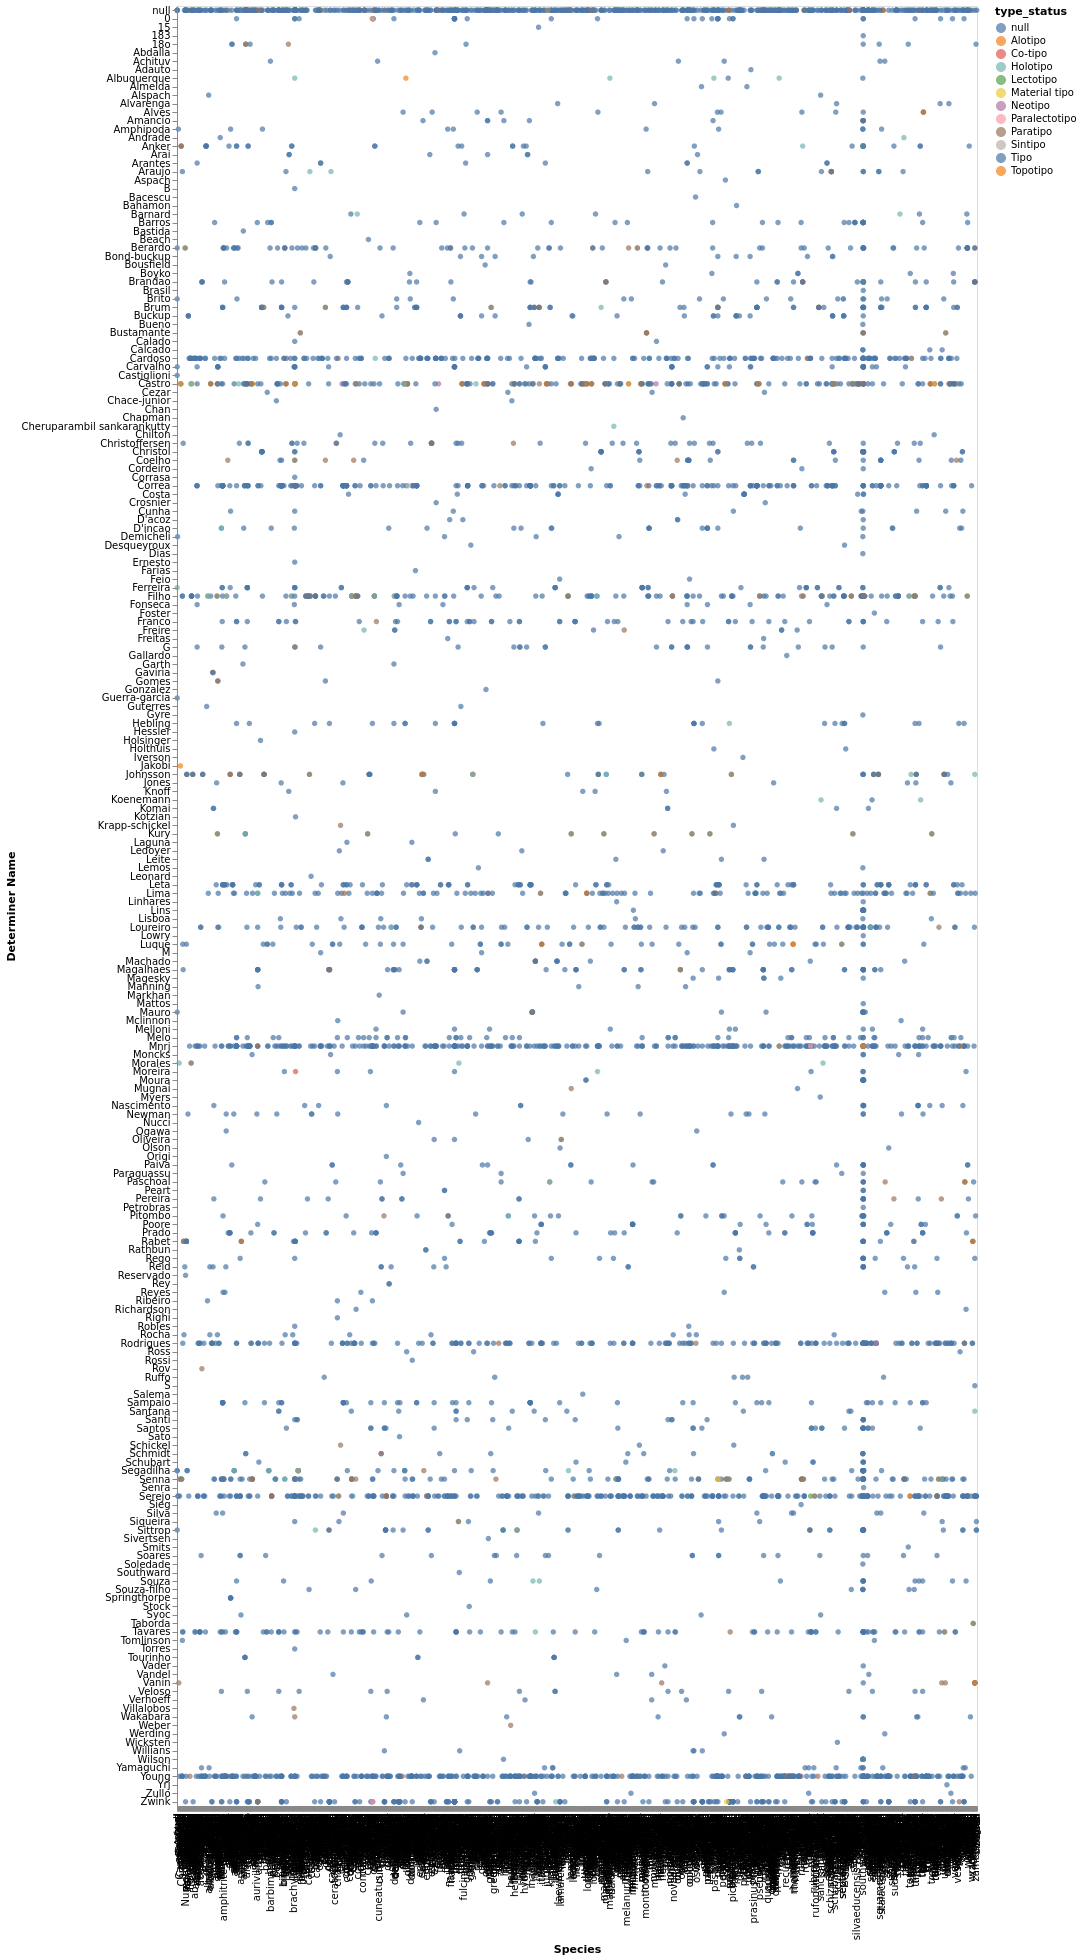

In [32]:
g2 = alt.Chart(teste1, width=800, height=1800).mark_circle().encode(
    x= alt.X('species', type='nominal', title='Species'),
    y= alt.Y('determiner_last_name', type='nominal', title='Determiner Name'),
    color= alt.Color('type_status')
)

# salvando o gráfico
# g2.save('determiner_and_species.svg')
# g2.save('determiner_and_species.html')

g2

In [79]:
type_data = teste1.groupby(['type_status','year']).count()['class'].reset_index().rename(
                                                    columns={'class':'counts'})

In [80]:
type_data.sort_values(['counts'], inplace=True)

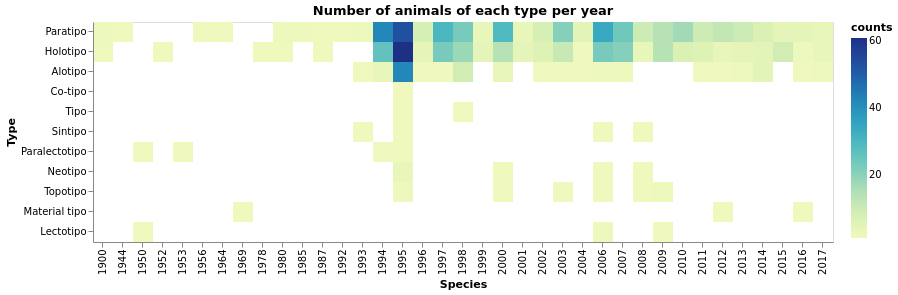

In [90]:
g3 = alt.Chart(type_data, title='Number of animals of each type per year').mark_rect().encode(
    x= alt.X('year', type='ordinal', title='Species'),
    y= alt.Y('type_status', type='nominal', title='Type', 
             sort=alt.EncodingSortField(field="counts", op="median", order='descending'),
            axis=alt.Axis(grid=False)),
    color= alt.Color('counts', type='quantitative', scale=alt.Scale(scheme='yellowgreenblue'))
)

# g3.save('types_per_year.html')
# g3.save('types_per_year.svg')

g3

<br>

-----

## Waffle Chart

In [91]:
ex = pd.ExcelFile('Dados gerais de coleção MN_29_09_19 enviado KELLNER_Asla.xlsx')
print(ex.sheet_names)

['Dados Gerais', 'Dados por coleção']


In [92]:
dados_gerais = ex.parse('Dados Gerais', sep=';', encoding='utf-8-sig')
dados_colecao = ex.parse('Dados por coleção', sep=';', encoding='utf-8-sig')

In [93]:
dados_colecao.head(2)

Unnamed: 0                            Coleção  \
0         DA    Arqueológica do Museu Nacional    
1         DA  Arqueobotânica do Museu Nacional    

                                             Curador  \
0  Rita Scheel-Ybert, Antonio Brancaglion Jr, Ang...   
1                                  Rita Scheel-Ybert   

   número de exemplares tombados e backlog  \
0                                   510674   
1                                   528187   

                                        sub-coleções  \
0  Reserva Técnica Principal da Arquelogia (Palác...   
1  Coleções Arqueobotânicas Arqueológicas (Antrac...   

   Material afetado no incêndio (N)  \
0                            153202   
1                            528187   

   Material afetado no incêndio (% do total)  Unnamed: 7  Unnamed: 8  
0                                   0.765019   29.999961         NaN  
1                                   2.637520  100.000000         NaN

In [94]:
dc = dados_colecao[['Unnamed: 0', 'Coleção', 'número de exemplares tombados e backlog', 
               'Material afetado no incêndio (N)',
               'Material afetado no incêndio (% do total)', 'Unnamed: 7']].copy()

In [95]:
dc.rename(columns={'Unnamed: 0':'dept', 'Coleção':'colecao', 
                   'número de exemplares tombados e backlog':'numero_exemp',
                   'Material afetado no incêndio (N)':'incendio', 
                    'Material afetado no incêndio (% do total)':'incendio_perc_total',
                    'Unnamed: 7':'incendio_perc_colecao'}, inplace=True)

In [96]:
dc['dept'] = dc['dept'].str.upper().str.strip()
dc['dept'] = dc['dept'].str.replace('DIREÇÃO', 'Direção')

In [97]:
dc['colecao'] = dc['colecao'].apply(lambda x:str(x).split('(')[0].strip())

In [98]:
# mudanças para encurtar o nome das coleções (p/ caber no frame da figura)
dc['colecao'] = dc['colecao'].str.replace('Centro de Documentação', 'Doc.')
dc['colecao'] = dc['colecao'].str.replace('do Museu Nacional', '').str.strip()
dc['colecao'] = dc['colecao'].str.replace('Biblioteca', 'Bib.')
dc['colecao'] = dc['colecao'].str.replace('Coleção de','')
dc['colecao'] = dc['colecao'].str.replace('COFRE DIREÇÃO', 'Cofre')
dc['colecao'] = dc['colecao'].str.replace('Coleção Didática de', '')

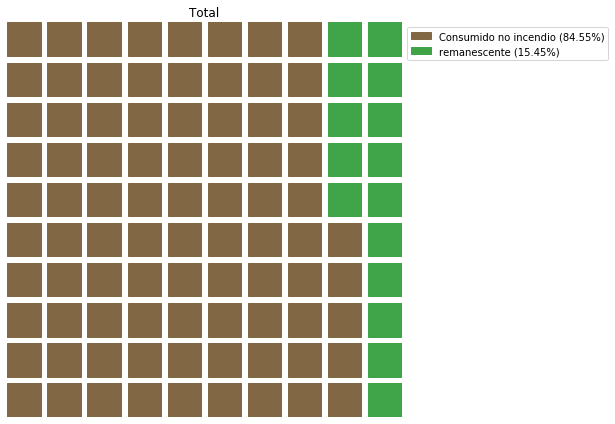

In [99]:
# Figura padrão
fig1 = plt.figure(
    FigureClass=Waffle, 
    rows=10, 
    columns=10, 
    values=[84.556, 100-84.556],
    colors=("#826745", "#3EA447"),
    title={'label': 'Total', 'loc': 'center'},
    labels=["{0} ({1}%)".format(k, v) for k, v in (('Consumido no incendio','84.55'),('remanescente' ,'{}'.format(round(100-84.55,2))))],
#     labels=["{0}".format(k) for k in ['consumido no incendio', 'remanescente']],
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
    icon_size=18,
    icon_legend=True,
#     legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'ncol': len(data), 'framealpha': 0},
    figsize=(10, 6)  # figsize is a parameter of matplotlib.pyplot.figure
)
plt.show()

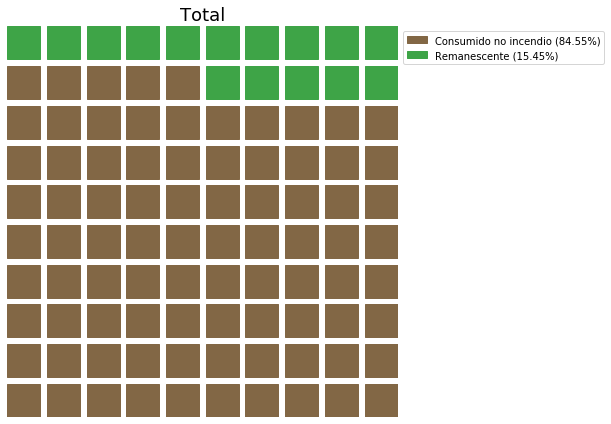

In [100]:
# Figura padrão
fig2 = plt.figure(
    FigureClass=Waffle, 
    rows=10, 
    columns=10, 
    values=[84.556, 100-84.556],
    colors=("#826745", "#3EA447"),
    title={'label': 'Total', 'loc': 'center', 'fontsize':18},
    labels=["{0} ({1}%)".format(k, v) for k, v in (('Consumido no incendio','84.55'),('Remanescente' ,'{}'.format(round(100-84.55,2))))],
#     labels=["{0}".format(k) for k in ['consumido no incendio', 'remanescente']],
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
    icon_size=18,
    icon_legend=True,
    vertical=True,
#     icons=['fire','square'],  # fire, campfire, heart, heart-o - OBS: pode passar a ideia errada,
#     characters='⬤',
#     font_size=30,
    figsize=(10, 6)  # figsize is a parameter of matplotlib.pyplot.figure
)
# plt.show()

plt.savefig('total.svg')
plt.savefig('total.png')

### criando dicionários para plot
cada linha deve ser um departamento, e cada coluna uma coleção

In [101]:
dc.head()

dept                    colecao  numero_exemp  incendio  \
0   DA               Arqueológica        510674    153202   
1   DA             Arqueobotânica        528187    528187   
2   DA     Antropologia Biológica          3000      3000   
3   DA      Setor de Etnográficas         41495     41495   
4   DA  Doc. de Línguas Indígenas         16093     16093   

   incendio_perc_total  incendio_perc_colecao  
0             0.765019              29.999961  
1             2.637520             100.000000  
2             0.014981             100.000000  
3             0.207207             100.000000  
4             0.080361             100.000000

In [102]:
# lista de departamentos ordenada de acordo com o número de coleções
deptos = dc['dept'].value_counts().sort_values(ascending=True).index

In [103]:
# for para dept
# for para colecao
# dict padrao
d = defaultdict()

index=0
adj = 0  # valor para ajuste das linhas (número de colunas para pular se acabar as coleções por depto)
for dept in deptos:
    temp = dc[dc['dept']==dept]
    
    row_count = temp.shape[0] # aumenta a linha com o número de dept
    
    adj = 10
    for c in range(temp['colecao'].shape[0]):
        
        adj -= 1
        index += 1
        val = round(temp.iloc[c-1].loc['incendio_perc_colecao'], 2)
        colecao = temp.iloc[c-1].loc['colecao']
        
        # criando dicionário para o gráfico
        d[(7,10,index)]= { 
                    'values':[val, 100-val],
                    'colors':("#826745", "#3EA447"),
                    'title':{'label': f'Depto.: {dept}\nCol.: {colecao}', 'loc': 'left', 'fontsize':14},
#                   'labels':["{0} ({1}%)".format(k, v) for k, v in data.items()],
#                   'labels':["{0}".format(k) for k in ['% da colecao consumida no incendio', '% remanescente da coleção']],
#                   'legend':{'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
#                     'icon_size':18, 
                    'icon_legend':True,
        }
    
        
        # pulando para a próxima linha
        if c == temp['colecao'].shape[0]-1:
            index = index + adj
        
d = dict(d)
# d

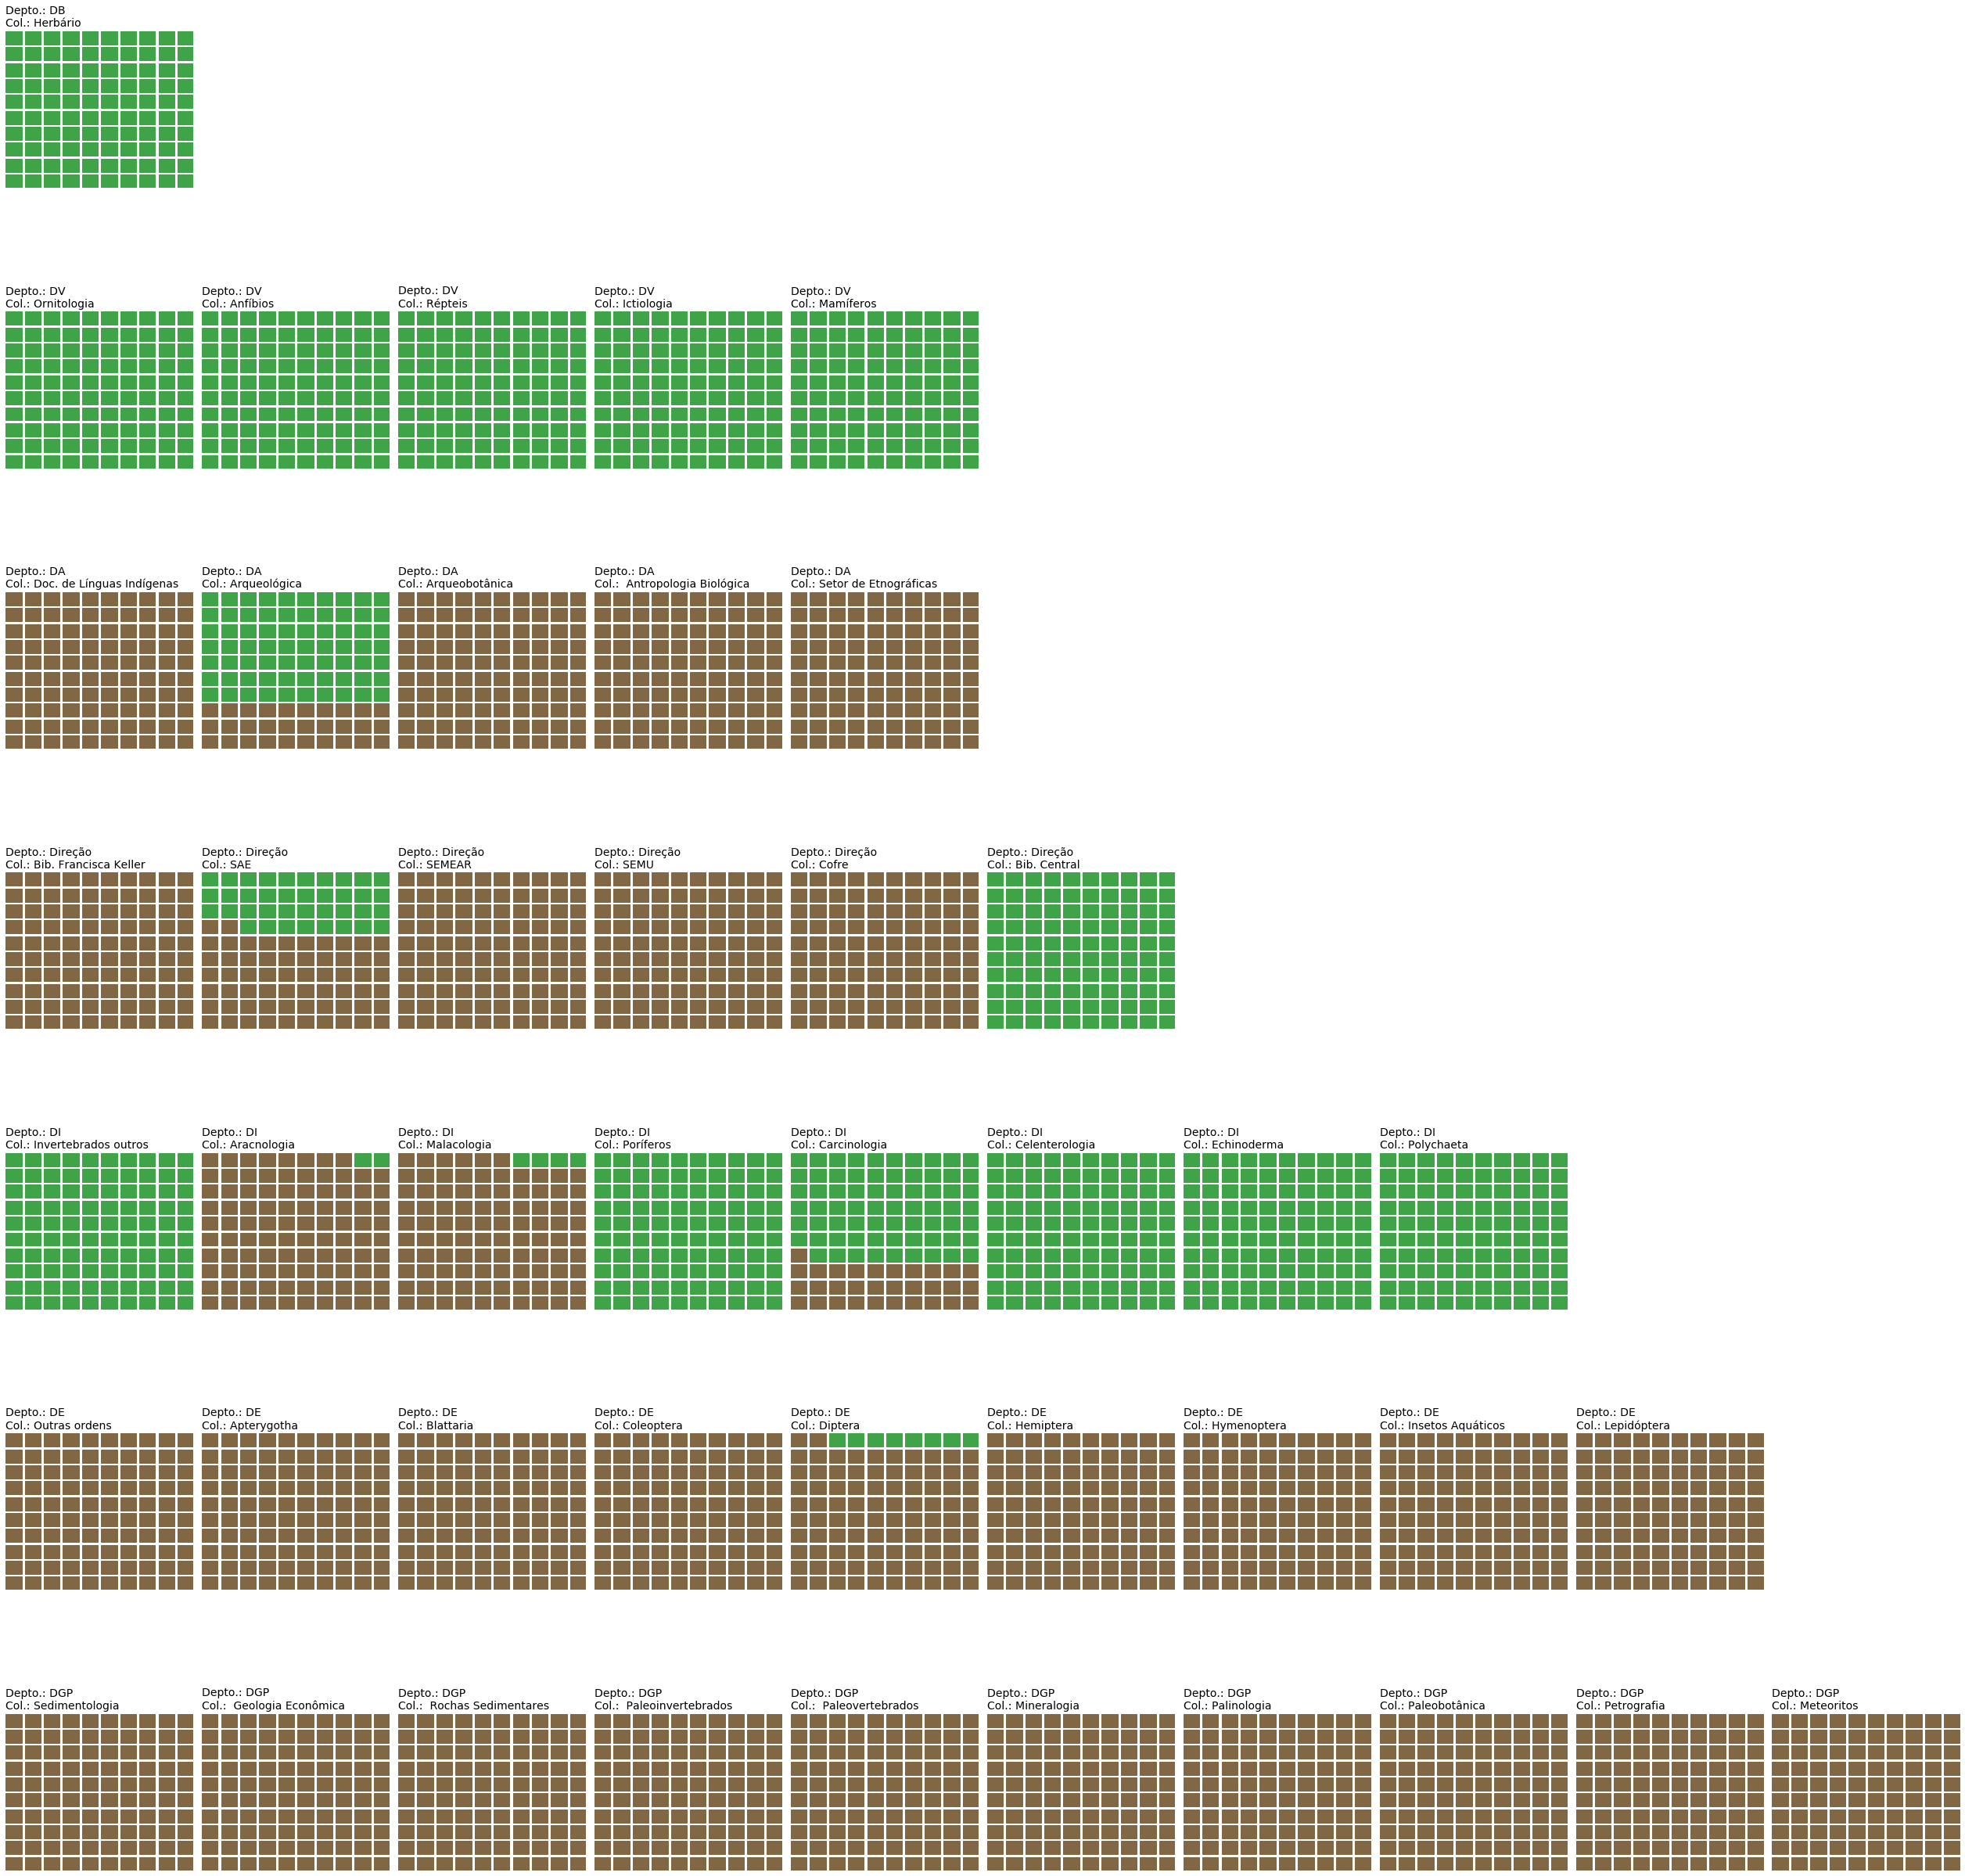

In [104]:
teste = plt.figure(
    FigureClass= Waffle,
    plots= d,
    rows=10, 
    columns=10, 
    vertical=True, 
    block_aspect_ratio=1.2,
    figsize=(35, 35)  # figsize is a parameter of matplotlib.pyplot.figure
)

# plt.savefig('waffle_colecao.svg')
# plt.savefig('waffle_colecao.png')

**<font color='red' size='5'>Ajustes</font>**

- idealmente, o nome do departamento deveria ficar nas colunas (editar o svg)
- adicionar legenda

In [328]:
temp = dc.copy()
temp['dept'].fillna('Total', inplace=True)

In [329]:
temp['Remanescentes'] = temp['numero_exemp'].astype(int) - temp['incendio'].astype(int)

In [330]:
temp = temp.rename(columns={'numero_exemp':'Total', 'incendio':'Consumidos'})

In [331]:
temp = temp.set_index(['colecao','incendio_perc_total','incendio_perc_colecao'])
temp = temp.groupby(['dept']).sum().stack().reset_index()
temp.columns = ['dept','nivel','num']

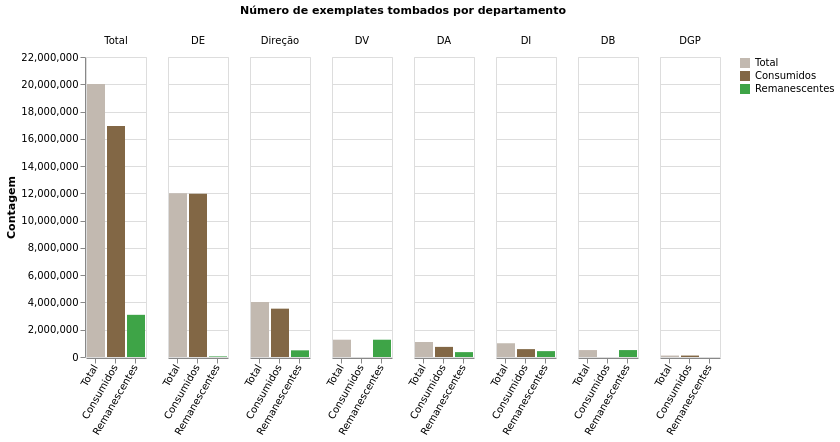

In [333]:
bar1 = alt.Chart(temp).mark_bar().encode(
    x = alt.X('nivel', sort= alt.EncodingSortField(field="nivel", op="mean", order='ascending'),
             title='', axis=alt.Axis(labelAngle=-60)),
    y= alt.Y('num', title='Contagem'), 
    color= alt.Color('nivel', scale= 
            alt.Scale(domain=['Total','Consumidos','Remanescentes'], 
                      range=['#c2b9b0','#826745','#3EA447'])
        , title=''),
    column=alt.Column('dept', sort= ['Total','DE','Direção','DV','DA','DI','DB','DGP'],
                     title='Número de exemplates tombados por departamento')
)

# bar1.save('exemp_por_dept.svg')
# bar1.save('exemp_por_dept.html')

bar1